Importing libraries

In [6]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag

# Visualizations
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.colors as colors

In [ ]:
from google.colab import files
uploaded = files.upload()

Importing and sampling review data

In [7]:
review_df = pd.read_json('Appliances.json', orient='records', lines=True)
review_df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5,2,False,"11 27, 2013",A3NHUQ33CFH3VM,1118461304,{'Format:': ' Hardcover'},Greeny,Not one thing in this book seemed an obvious o...,Clear on what leads to innovation,1385510400,NaN
1,5,NaN,False,"11 1, 2013",A3SK6VNBQDNBJE,1118461304,{'Format:': ' Kindle Edition'},Leif C. Ulstrup,I have enjoyed Dr. Alan Gregerman's weekly blo...,Becoming more innovative by opening yourself t...,1383264000,NaN
2,5,NaN,False,"10 10, 2013",A3SOFHUR27FO3K,1118461304,{'Format:': ' Hardcover'},Harry Gilbert Miller III,Alan Gregerman believes that innovation comes ...,The World from Different Perspectives,1381363200,NaN
3,5,NaN,False,"10 9, 2013",A1HOG1PYCAE157,1118461304,{'Format:': ' Hardcover'},Rebecca Ripley,"Alan Gregerman is a smart, funny, entertaining...",Strangers are Your New Best Friends,1381276800,NaN
4,5,10,False,"09 7, 2013",A26JGAM6GZMM4V,1118461304,{'Format:': ' Hardcover'},Robert Morris,"As I began to read this book, I was again remi...","How and why it is imperative to engage, learn ...",1378512000,NaN


Preprocessing review data

In [8]:
#Looking for columns with missing values and updating the column names
display(review_df.shape)
review_df.isna().any()
review_df = review_df.rename(columns={'overall': 'Rating'})

(602777, 12)

Importing and sampling the meta data

In [9]:
dfmeta = pd.read_json('meta_appliances.json', orient='records', lines=True)
dfmeta.head()

,category,tech1,description,fit,title,also_buy,image,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin
0,"[Appliances, Refrigerators, Freezers & Ice Mak...","class=""a-keyvalue prodDetTable"" role=""present...",[],,Tupperware Freezer Square Round Container Set ...,[],[],,Tupperware,[Each 3-pc. set includes two 7/8-cup/200 mL an...,"[>#39,745 in Appliances (See top 100)]",[],{},Appliances,,"November 19, 2008",,7301113188
1,"[Appliances, Refrigerators, Freezers & Ice Mak...","class=""a-keyvalue prodDetTable"" role=""present...",[2 X Tupperware Pure & Fresh Unique Covered Co...,,2 X Tupperware Pure &amp; Fresh Unique Covered...,[],[https://images-na.ssl-images-amazon.com/image...,,Tupperware,[2 X Tupperware Pure & Fresh Unique Covered Co...,"[>#6,118 in Appliances (See top 100)]",[B004RUGHJW],{},Appliances,,"June 5, 2016",$3.62,7861850250
2,"[Appliances, Parts &amp; Accessories]",,[],,The Cigar - Moments of Pleasure,[],[https://images-na.ssl-images-amazon.com/image...,,The Cigar Book,[],"[>#1,861,816 in Home &amp; Kitchen (See Top 10...","[B01HCAVSLK, 1632206579]",{},Amazon Home,,,$150.26,8792559360
3,"[Appliances, Parts & Accessories]","class=""a-keyvalue prodDetTable"" role=""present...","[Multi purpost descaler, especially suited to ...",,Caraselle 2X 50G Appliance Descalene,[],[https://images-na.ssl-images-amazon.com/image...,,Caraselle,[],"[>#1,654,505 in Tools & Home Improvement (See ...",[],{},Tools & Home Improvement,,"December 17, 2014",.a-box-inner{background-color:#fff}#alohaBuyBo...,9792954481
4,"[Appliances, Parts & Accessories, Range Parts ...","class=""a-keyvalue prodDetTable"" role=""present...",[Full gauge and size beveled-edge; furnished w...,,EATON Wiring 39CH-SP-L Arrow Hart 1-Gang Chrom...,[],[],,EATON Wiring,[Returns will not be honored on this closeout ...,"[>#3,066,990 in Tools & Home Improvement (See ...",[],{},Tools & Home Improvement,,"January 16, 2007",$3.43,B00002N5EL


Preprocessing the meta data

In [ ]:
display(dfmeta.shape)
dfmeta.isna().any()

Merging review data with meta data

In [11]:
product_reviews=pd.merge(review_df,dfmeta,on='asin',how='inner')
product_reviews.head()

,Rating,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image_x,category,tech1,description,fit,title,also_buy,image_y,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price
0,5,NaN,True,"03 20, 2015",A3SHVDMM83IHJ4,B00002N7IL,{'Size:': ' Pack of 1'},steve crumpler,Just what I needed for my electric range. Matc...,Matched pigtail cord and works great.,1426809600,NaN,"[Appliances, Parts & Accessories, Range Parts ...","class=""a-keyvalue prodDetTable"" role=""present...",[Outfit your dryer with top-notch connections ...,,"Leviton 5206 50 Amp, 125/250 Volt, NEMA 10-50R...","[B000FK9X6W, B000BPFZHM, B000FP8LK6, B00002N7H...",[],,Leviton,"[Fits all wallplates with 2.15"" diameter cente...","[>#411,187 in Tools & Home Improvement (See to...","[B00002N7HY, B074Q2KZGV, B000FPCL2K, B000FP8LK...",{},Tools & Home Improvement,"class=""a-bordered a-horizontal-stripes a-spa...","July 7, 2004",
1,5,NaN,True,"03 20, 2015",A3SHVDMM83IHJ4,B00002N7IL,{'Size:': ' Pack of 1'},steve crumpler,Just what I needed for my electric range. Matc...,Matched pigtail cord and works great.,1426809600,NaN,"[Appliances, Parts & Accessories, Range Parts ...","class=""a-keyvalue prodDetTable"" role=""present...",[Outfit your dryer with top-notch connections ...,,"Leviton 5206 50 Amp, 125/250 Volt, NEMA 10-50R...","[B000FK9X6W, B000BPFZHM, B000FP8LK6, B00002N7H...",[],,Leviton,"[Fits all wallplates with 2.15"" diameter cente...","[>#411,187 in Tools & Home Improvement (See to...","[B00002N7HY, B074Q2KZGV, B000FPCL2K, B000FP8LK...",{},Tools & Home Improvement,"class=""a-bordered a-horizontal-stripes a-spa...","July 7, 2004",
2,5,NaN,True,"03 26, 2018",A3TIWHNJXMSIU7,B00002N7IL,{'Size:': ' Pack of 1'},Torpex,this particular type is perfect and easily ada...,this particular type is perfect and easily ada...,1522022400,NaN,"[Appliances, Parts & Accessories, Range Parts ...","class=""a-keyvalue prodDetTable"" role=""present...",[Outfit your dryer with top-notch connections ...,,"Leviton 5206 50 Amp, 125/250 Volt, NEMA 10-50R...","[B000FK9X6W, B000BPFZHM, B000FP8LK6, B00002N7H...",[],,Leviton,"[Fits all wallplates with 2.15"" diameter cente...","[>#411,187 in Tools & Home Improvement (See to...","[B00002N7HY, B074Q2KZGV, B000FPCL2K, B000FP8LK...",{},Tools & Home Improvement,"class=""a-bordered a-horizontal-stripes a-spa...","July 7, 2004",
3,5,NaN,True,"03 26, 2018",A3TIWHNJXMSIU7,B00002N7IL,{'Size:': ' Pack of 1'},Torpex,this particular type is perfect and easily ada...,this particular type is perfect and easily ada...,1522022400,NaN,"[Appliances, Parts & Accessories, Range Parts ...","class=""a-keyvalue prodDetTable"" role=""present...",[Outfit your dryer with top-notch connections ...,,"Leviton 5206 50 Amp, 125/250 Volt, NEMA 10-50R...","[B000FK9X6W, B000BPFZHM, B000FP8LK6, B00002N7H...",[],,Leviton,"[Fits all wallplates with 2.15"" diameter cente...","[>#411,187 in Tools & Home Improvement (See to...","[B00002N7HY, B074Q2KZGV, B000FPCL2K, B000FP8LK...",{},Tools & Home Improvement,"class=""a-bordered a-horizontal-stripes a-spa...","July 7, 2004",
4,5,NaN,True,"03 20, 2018",AVP16JFIT6LPL,B00002N7IL,{'Size:': ' Pack of 1'},RAFAEL FERNANDEZ,excellent,Five Stars,1521504000,NaN,"[Appliances, Parts & Accessories, Range Parts ...","class=""a-keyvalue prodDetTable"" role=""present...",[Outfit your dryer with top-notch connections ...,,"Leviton 5206 50 Amp, 125/250 Volt, NEMA 10-50R...","[B000FK9X6W, B000BPFZHM, B000FP8LK6, B00002N7H...",[],,Leviton,"[Fits all wallplates with 2.15"" diameter cente...","[>#411,187 in Tools & Home Improvement (See to...","[B00002N7HY, B074Q2KZGV, B000FPCL2K, B000FP8LK...",{},Tools & Home Improvement,"class=""a-bordered a-horizontal-stripes a-spa...","July 7, 2004",


Preprocessing the new data

In [12]:
#Selecting the required columns for the analysis
product_reviews.shape
product_reviews.isna().any()
mainproduct=product_reviews[['Rating' , 'asin' , 'reviewerID', 'rank', 'price']]

In [ ]:
#Adding rating mean and count for each product
mainproduct['count']=mainproduct.asin.groupby(mainproduct.asin).transform('count')
mainproduct['mean']=mainproduct.groupby('asin')['Rating'].transform('mean')

In [14]:
#Dropping duplicate products and irrelevant columns
mainproduct=mainproduct.drop_duplicates(['asin']).reset_index(drop=True)
mainproduct=mainproduct.drop('Rating', axis=1)
mainproduct=mainproduct.drop('reviewerID', axis=1)

In [15]:
#Finding the sales rank of each product
mainproduct['sales'] = (mainproduct['rank'].str[0]).str[2:9]
(mainproduct['sales'].shape)[0]
mainproduct['sales'].replace('', np.nan, inplace=True)
mainproduct=mainproduct[mainproduct['sales'].notna()].reset_index(drop=True)
for x in range((mainproduct['sales'].shape)[0]):
    mainproduct.loc[x,'sales']=int("".join(filter(str.isdigit, mainproduct.loc[x , 'sales'])))
mainproduct.sales = mainproduct.sales.astype(float)

In [16]:
#Number of products without a price
mainproduct['price'].replace('', np.nan, inplace=True)
sum(mainproduct['price'].isna())

9683

In [17]:
#Filling NaN values with the average price of the products
mainproduct['price'] = mainproduct['price'].str[1:8]
mean_price = mainproduct['price'].dropna()
mean_price = pd.to_numeric(mean_price, errors='coerce')
mp=mean_price.mean()
mainproduct['price'] = pd.to_numeric(mainproduct['price'],errors='coerce')
mainproduct['price']=mainproduct['price'].fillna(mp)

In [18]:
#number of unique products for the analysis
mainproduct.shape[0]

28627

In [21]:
#Sample of the processed data
mainproduct.head(10)

,asin,rank,price,count,mean,sales
0,B00002N7IL,"[>#411,187 in Tools & Home Improvement (See to...",52.82997,22,4.909091,411187.0
1,B00004SQHD,"[>#728,958 in Tools & Home Improvement (See to...",1.41000,64,4.593750,728958.0
2,B00004YWK2,"[>#78,624 in Tools & Home Improvement (See top...",9.90000,522,3.908046,78624.0
3,B00004YWK7,"[>#157,857 in Tools &amp; Home Improvement (Se...",19.78000,40,3.800000,157857.0
4,B000056J8D,"[>#254,487 in Home & Kitchen (See Top 100 in H...",52.82997,94,4.680851,254487.0
5,B00005OU6T,"[>#1,235 in Home & Kitchen (See Top 100 in Hom...",5.98000,500,3.820000,1235.0
6,B00006IV17,"[>#1,074 in Home & Kitchen (See Top 100 in Hom...",11.89000,1530,4.326797,1074.0
7,B00006JKZX,"[>#25,110 in Appliances (See top 100), >#232 i...",52.82997,72,3.388889,25110.0
8,B00007E7RZ,"[>#81,786 in Home & Kitchen (See Top 100 in Ho...",20.99000,128,3.718750,81786.0
9,B00007E7RQ,"[>#1,123 in Home & Kitchen (See Top 100 in Hom...",11.76000,490,4.126531,1123.0


Data statistics and distributions

In [23]:
# counts for each star
number=product_reviews['Rating'].value_counts()
number

5    424791
4     77648
1     60530
3     31576
2     21202
Name: Rating, dtype: int64

In [24]:
#counts for number of reviews
out = pd.cut(mainproduct['count'], bins=[0.001, 1, 5, 10,25,100,1000,10000], include_lowest=True)
out_norm = out.value_counts(sort=False, normalize=True).mul(100)
out_norm

(0.0, 1.0]           34.383624
(1.0, 5.0]           33.052712
(5.0, 10.0]          10.668250
(10.0, 25.0]          9.679673
(25.0, 100.0]         8.362734
(100.0, 1000.0]       3.657386
(1000.0, 10000.0]     0.195620
Name: count, dtype: float64

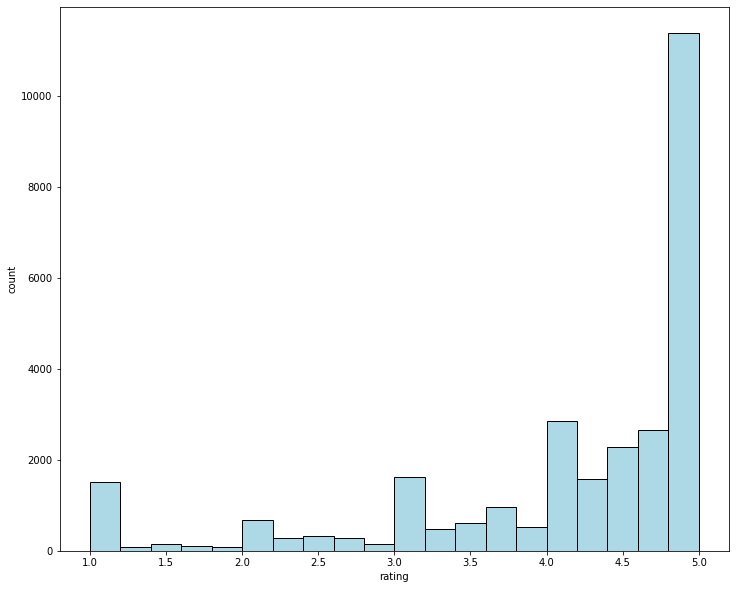

In [30]:
# histogram 1 disturbution of average ratings
plt.figure(figsize=(12,10))
plt.hist(mainproduct['mean'], color = 'lightblue', edgecolor = 'black', bins=20)
# Add labels
plt.xlabel('rating'); plt.ylabel('count');

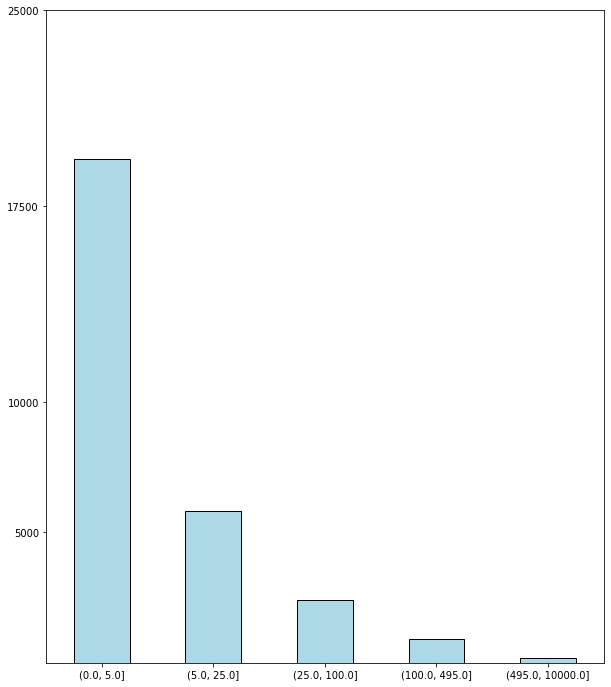

In [31]:
# histogram 2 disturbution of review counts
out = pd.cut(mainproduct['count'], bins=[0.001, 5, 25,100,495,10000], include_lowest=True)
ax = out.value_counts(sort=False).plot.bar(rot=0, color='lightblue', edgecolor='black', figsize=(10,12))
plt.yticks([5000, 10000, 17500,25000])
plt.show()

In [32]:
#Data statistics
describe_df=mainproduct[['sales','mean','count','price']]
table=describe_df.describe()
table.loc['+3_std'] = table.loc['mean'] + (table.loc['std'] * 3)
table.loc['-3_std'] = table.loc['mean'] - (table.loc['std'] * 3)
table

,sales,mean,count,price
count,2.862700e+04,28627.000000,28627.000000,28627.000000
mean,2.177414e+05,4.134178,20.652461,52.829970
std,2.835205e+05,1.116629,108.207553,57.071297
min,1.000000e+00,1.000000,1.000000,0.190000
25%,1.491150e+04,3.750000,1.000000,21.425000
50%,4.156800e+04,4.565217,3.000000,52.829970
75%,3.766155e+05,5.000000,9.000000,52.829970
max,9.999650e+05,5.000000,6510.000000,999.990000
+3_std,1.068303e+06,7.484067,345.275119,224.043862
-3_std,-6.328201e+05,0.784290,-303.970197,-118.383922


Analyzing Skewness and Kurtosis and transforming the data

Stats library computes excess kurtosis, therefore both skewness and kurtosis should be close to 0.

In [33]:
from scipy.stats import kurtosis , skew

col = ['sales', 'mean', 'price', 'count']
for x in col:
  print("..........")
  print(x)
  print("skewness")
  print(skew(mainproduct[x]))
  print("kurtosis")
  print(kurtosis(mainproduct[x]))

..........
sales
skewness
1.241967023150733
kurtosis
0.2290091613652545
..........
mean
skewness
-1.4913703341256845
kurtosis
1.372204062898244
..........
price
skewness
5.598374758012795
kurtosis
53.4705485357833
..........
count
skewness
23.447945330415365
kurtosis
947.1662590533938


In [35]:
from scipy import stats

for x in col:
  p_value = stats.shapiro(mainproduct[x])[1]
  if p_value <= 0.05:
    print(x)
    print(":Null hypothesis of normality is rejected\n")
  else:
    print(x)
    print(":Null hypothesis of normality is accepted\n")

sales
:Null hypothesis of normality is rejected

mean
:Null hypothesis of normality is rejected

price
:Null hypothesis of normality is rejected

count
:Null hypothesis of normality is rejected



/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Normality is rejected and the data is skewed, therefore we use log transformation.

In [36]:
#Adding log values to the data set
mainproduct['logsales'] = np.log(mainproduct['sales'])
mainproduct['logcount'] = np.log(mainproduct['count'])
mainproduct['logmean'] = np.log(mainproduct['mean'])
mainproduct['logprice'] = np.log(mainproduct['price'])

In [37]:
#Removing outliers

remove_df=mainproduct[['logmean','logsales','logprice','logcount']]
remove_df = remove_df[(np.abs(stats.zscore(remove_df)) < 3).all(axis=1)]


In [39]:
#Number of products after removing the outliers
remove_df.shape[0]

26529

Correlation can show the relationship between two variables.

In [40]:
# correlation coeifficeint 
remove_df.corr()

,logmean,logsales,logprice,logcount
logmean,1.000000,0.116944,-0.054552,-0.096105
logsales,0.116944,1.000000,-0.059368,0.023695
logprice,-0.054552,-0.059368,1.000000,-0.168622
logcount,-0.096105,0.023695,-0.168622,1.000000


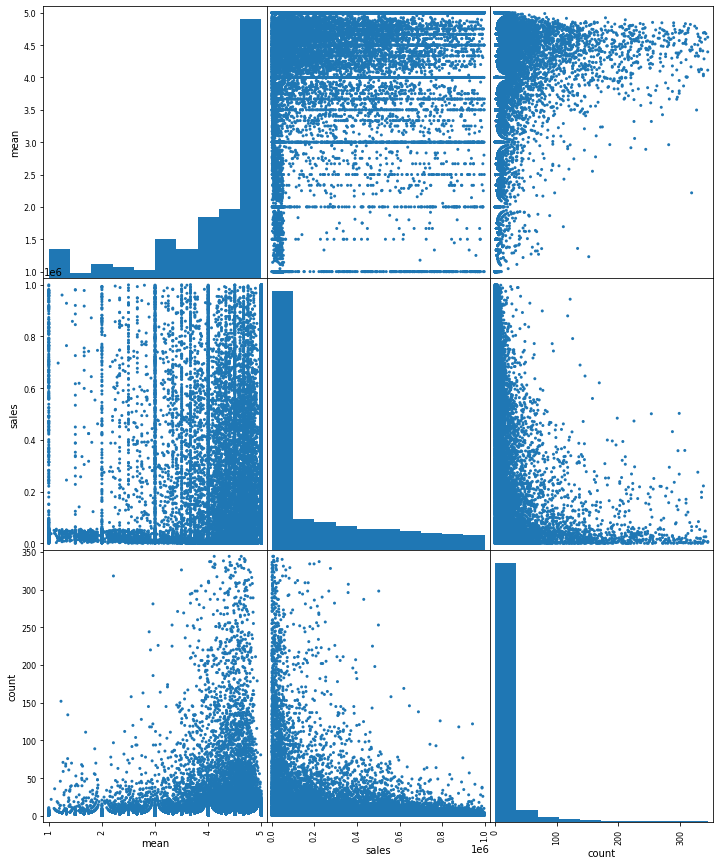

In [41]:
#scatter plot
scatter=mainproduct[['mean','sales','count']]
scatter = scatter[(np.abs(stats.zscore(scatter)) < 3).all(axis=1)]
pd.plotting.scatter_matrix(scatter, alpha = 1, figsize = (12, 15))
plt.show()

Model Building

We creat a linear regression model to evaluate the relationship between sales with average rating and number of reviews

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#define our input variable (X) & output variable
model = remove_df[['logsales','logmean', 'logcount','logprice']]

x= remove_df[['logmean','logcount','logprice']]
y = remove_df[['logsales']]

# Spliting the data into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1)

# create a Linear Regression model object
regression_model = LinearRegression()

# pass through the X_train & y_train data set
regression_model.fit(x_train, y_train)


LinearRegression()

In [44]:
# model output
# let's grab the coefficient of our model and the intercept
intercept = regression_model.intercept_[0]
coefficent = regression_model.coef_[0][0]

print("The intercept for our model is {:.4}".format(intercept))
print('-'*100)

#Printing the results
for coef in zip(x.columns, regression_model.coef_[0]):
    print("The Coefficient for {} is {:.2}".format(coef[0],coef[1]))

The intercept for our model is 10.22
----------------------------------------------------------------------------------------------------
The Coefficient for logmean is 0.85
The Coefficient for logcount is 0.042
The Coefficient for logprice is -0.099


Model output

In [45]:
#model output table
x2 = sm.add_constant(x)

# create a OLS model
models = sm.OLS(y, x2)

# fit the data
est = models.fit()
# print out a summary
print(est.summary())


                            OLS Regression Results                            
Dep. Variable:               logsales   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     154.6
Date:                Wed, 22 Dec 2021   Prob (F-statistic):           2.64e-99
Time:                        07:21:42   Log-Likelihood:                -52483.
No. Observations:               26529   AIC:                         1.050e+05
Df Residuals:                   26525   BIC:                         1.050e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.2786      0.085    121.406      0.0

Creating a new data set for and building a new model for products with more than 10 ratings.

In [52]:
#New data for hypothesis 3

#Number of products with more than 10 ratings
test3 = mainproduct[mainproduct['count'] > 10]  
(test3.shape)[0]

6268

In [48]:
#New model for hypothesis 3
hype=test3[['logmean','logprice','logcount','logsales']]
x= hype[['logmean','logcount','logprice']]
y = hype[['logsales']]

#Spliting the data into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1)

#Create a Linear Regression model object
regression_model3 = LinearRegression()

#Pass through the X_train & y_train data set
regression_model3.fit(x_train, y_train)

LinearRegression()

In [49]:
#Let's grab the coefficient of our model and the intercept
intercept = regression_model3.intercept_[0]
coefficent = regression_model3.coef_[0][0]

print("The intercept for our model is {:.4}".format(intercept))
print('-'*100)

#Printing the results
for coef in zip(x.columns, regression_model3.coef_[0]):
    print("The Coefficient for {} is {:.2}".format(coef[0],coef[1]))

The intercept for our model is 11.05
----------------------------------------------------------------------------------------------------
The Coefficient for logmean is 1.5
The Coefficient for logcount is -0.67
The Coefficient for logprice is 0.025


Model 2 Output

In [50]:
#hypothesis 3 model results
x3 = sm.add_constant(x)

# create a OLS model
models3 = sm.OLS(y, x3)

# fit the data
est3 = models3.fit()

# print out a summary
print(est3.summary())

                            OLS Regression Results                            
Dep. Variable:               logsales   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     345.8
Date:                Wed, 22 Dec 2021   Prob (F-statistic):          8.01e-208
Time:                        07:22:12   Log-Likelihood:                -12670.
No. Observations:                6268   AIC:                         2.535e+04
Df Residuals:                    6264   BIC:                         2.537e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.9672      0.216     50.730      0.0